<a href="https://colab.research.google.com/github/EmmaMuhleman1/Adv_Fin_ML_Exercises/blob/master/NDX_GradientBoosting_Rewritten_Executed_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NDX Gradient Boosting Final Report

This notebook executes the complete predictive modeling pipeline on the Nasdaq-100 index, using XGBoost and confidence-weighted strategy backtesting.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from sklearn.model_selection import train_test_split, TimeSeriesSplit, RandomizedSearchCV
from sklearn.metrics import (roc_auc_score, roc_curve, accuracy_score,
                             confusion_matrix, classification_report, auc)
from xgboost import XGBClassifier
import shap
import warnings
warnings.filterwarnings('ignore')
sns.set(style='whitegrid', context='notebook')

In [5]:
df = yf.download('^NDX', start='2008-01-01', progress=False).reset_index()
df.columns = df.columns.droplevel('Ticker').str.title()
df['Return'] = df['Close'].pct_change()
df['Target'] = (df['Return'].shift(-1) > 0.0025).astype(int)

In [6]:
for n in [1, 5, 10, 15, 20]:
    df[f'Return_Lag_{n}'] = df['Close'].pct_change(n)
df['Volatility_10'] = df['Return'].rolling(10).std()
df['Volatility_20'] = df['Return'].rolling(20).std()
range_pct = (df['High'] - df['Low']) / df['Close']
df['Range_Z'] = (range_pct - range_pct.rolling(20).mean()) / range_pct.rolling(20).std()
df['Volume_Z'] = (df['Volume'] - df['Volume'].rolling(20).mean()) / df['Volume'].rolling(20).std()
df['MA50_Diff'] = df['Close'] / df['Close'].rolling(50).mean() - 1
df['MA200_Diff'] = df['Close'] / df['Close'].rolling(200).mean() - 1
delta = df['Close'].diff()
gain = delta.where(delta > 0, 0).rolling(14).mean()
loss = -delta.where(delta < 0, 0).rolling(14).mean()
rs = gain / loss
df['RSI'] = 100 - (100 / (1 + rs))
df['Close_Position'] = (df['Close'] - df['Low']) / (df['High'] - df['Low'])
df['Weekday'] = df['Date'].dt.dayofweek
df['Month'] = df['Date'].dt.month
df = pd.get_dummies(df, columns=['Weekday', 'Month'], drop_first=True)
df.dropna(inplace=True)

In [7]:
features = [col for col in df.columns if col.startswith(('Return_Lag_', 'Volatility_', 'Range_Z',
           'Volume_Z', 'MA50_Diff', 'MA200_Diff', 'RSI', 'Close_Position', 'Weekday_', 'Month_'))]
X = df[features]
y = df['Target']
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2)

In [8]:
baseline_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
baseline_model.fit(X_train, y_train)
train_preds = baseline_model.predict(X_train)
test_preds = baseline_model.predict(X_test)
train_acc = accuracy_score(y_train, train_preds)
test_acc = accuracy_score(y_test, test_preds)
print(f"Training Accuracy: {train_acc:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

Training Accuracy: 0.9991
Test Accuracy: 0.4941


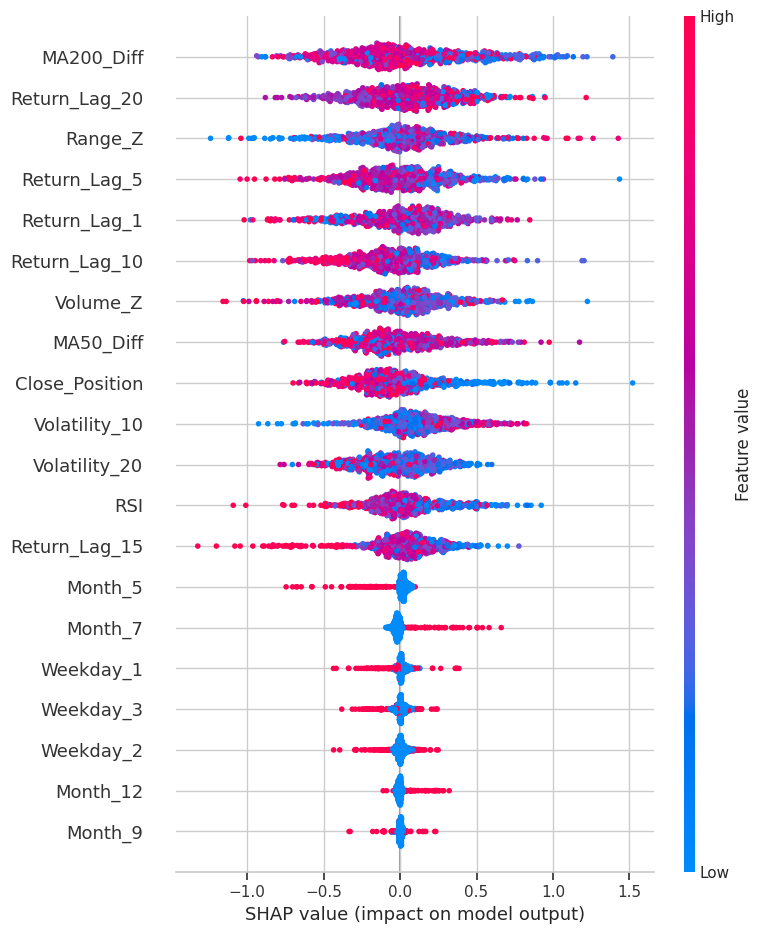

In [9]:
explainer = shap.TreeExplainer(baseline_model)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)